In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tensorflow import keras

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test)=fashion_mnist.load_data()

In [4]:
x_valid,x_train=x_train_all[:5000],x_train_all[5000:]

In [5]:
y_valid,y_train=y_train_all[:5000],y_train_all[5000:]
print(x_train.shape)
print(np.max(x_train))

(55000, 28, 28)
255


In [6]:
# x=(x-u)/std
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [7]:
print(np.max(x_train_scaled))

2.0231433


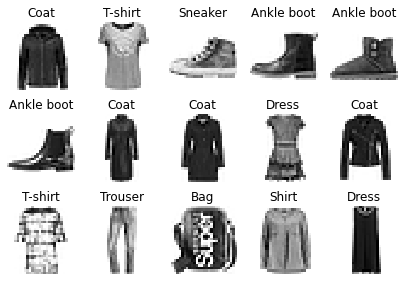

In [8]:
def show_single_image(img_arr):
    plt.imshow(img_arr,cmap='binary')
    plt.show()
    
def show_imgs(n_rows,n_cols,x_data,y_data,class_names):
    assert len(x_data) == len(y_data)
    assert n_rows*n_cols < len(x_data)
    plt.figure(figsize=(n_cols*1.4,n_rows*1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols*row + col
            plt.subplot(n_rows,n_cols,index+1)
            plt.imshow(x_data[index],cmap='binary',interpolation='nearest')
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()
    
class_names=['T-shirt','Trouser','Pullover','Dress',
             'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
show_imgs(3,5,x_train,y_train,class_names)

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))
# softmax:将向量变成概率分布 y=[e^x1/sum,e^x2/sum...,sum=e^x1+e^x2+e^x3]
# sparse : y->index只是一个数 . y->onehot->[]
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',
             metrics=['accuracy'])

In [10]:
model.layers

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Tensorboard earlystopping modelcheckpoint
# logdir = './graph_def_and_weights'
# if not os.path.exists(logdir):
#     os.mkdir(logdir)
# output_model_file = os.path.join(logdir,'fashion_mnist_model.h5')


# [None,784] * w +b ->[None,300] w.shape [784,300] ,b=[300]
history=model.fit(x_train_scaled,y_train,epochs=10,
                  validation_data=(x_valid_scaled,y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 121us/sample - loss: 0.5385 - accuracy: 0.8110 - val_loss: 0.4024 - val_accuracy: 0.8576
Epoch 2/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.3921 - accuracy: 0.8595 - val_loss: 0.3712 - val_accuracy: 0.8686
Epoch 3/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.3526 - accuracy: 0.8723 - val_loss: 0.3560 - val_accuracy: 0.8740
Epoch 4/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.3286 - accuracy: 0.8812 - val_loss: 0.3343 - val_accuracy: 0.8812
Epoch 5/10
55000/55000 [==============================] - 5s 100us/sample - loss: 0.3089 - accuracy: 0.8887 - val_loss: 0.3217 - val_accuracy: 0.8850
Epoch 6/10
55000/55000 [==============================] - 5s 96us/sample - loss: 0.2928 - accuracy: 0.8936 - val_loss: 0.3199 - val_accuracy: 0.8838
Epoch 7/10
55000/55000 [==============================]

In [13]:
type(history)

tensorflow.python.keras.callbacks.History

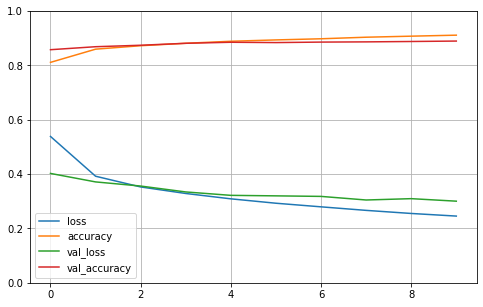

In [14]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [15]:
tf.saved_model.save(model,'./saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_model/assets


In [17]:
!saved_model_cli show --dir ./saved_model/ --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['flatten_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: serving_default_flatten_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


In [20]:
!saved_model_cli show --dir ./saved_model/ --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28)
      name: serving_default_flatten_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [21]:
!saved_model_cli run --dir ./saved_model/ --tag_set serve \
    --signature_def serving_default \
    --input_exprs 'flatten_input=np.ones((2,28,28))'

2020-11-19 12:21:57.073617: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-11-19 12:21:57.093399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:02:00.0
2020-11-19 12:21:57.094698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:03:00.0
2020-11-19 12:21:57.095764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:82:00.0
2020-11-19 12:21:57.096729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:83:00.0

In [22]:
loaded_saved_model = tf.saved_model.load('./saved_model/')
print(list(loaded_saved_model.signatures.keys()))

['serving_default']


In [25]:
inference = loaded_saved_model.signatures['serving_default']
print(inference.structured_outputs)

{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [28]:
results = inference(tf.constant(x_test_scaled[0:1]))
results

{'dense_2': <tf.Tensor: id=58220, shape=(1, 10), dtype=float32, numpy=
 array([[2.8250534e-07, 7.8539109e-08, 6.6272719e-07, 5.8744956e-07,
         1.6988639e-05, 1.3521292e-03, 1.4161519e-05, 7.9214470e-03,
         2.6696691e-05, 9.9066693e-01]], dtype=float32)>}

In [29]:
results['dense_2']

<tf.Tensor: id=58220, shape=(1, 10), dtype=float32, numpy=
array([[2.8250534e-07, 7.8539109e-08, 6.6272719e-07, 5.8744956e-07,
        1.6988639e-05, 1.3521292e-03, 1.4161519e-05, 7.9214470e-03,
        2.6696691e-05, 9.9066693e-01]], dtype=float32)>